In [90]:
import os
import csv

import random
import numpy as np

from sklearn.metrics import matthews_corrcoef
from sklearn.manifold.t_sne import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

##Hierarchical clustering
def Hclust(data, n_clusters):
    best_silh = 0
    for n in range(2,20,1):
        hclust = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        tmp_label = hclust.fit_predict(data).tolist()
        tmp_silh = silhouette_score(data, tmp_label)
        if tmp_silh > best_silh:
            best_silh = tmp_silh
            n_clust = n
            label = tmp_label
    return n_clust, label

## Clustering CNN+AE encoded vectors

In [86]:
disease_folder = 'autism'
date_time_folder = '2018-10-23-17-35-48'
experiment_folder = 'autism2018-10-26-16-9-58'
data_folder = os.path.expanduser('~/data1/complex_disorders/data/%s/cohorts/%s' % (disease_folder, date_time_folder))

In [87]:
with open(os.path.expanduser('~/data1/complex_disorders/experiments/%s' % experiment_folder) + '/encoded_vect.csv') as f:
    rd = csv.reader(f)
    encoded_vect = []
    for r in rd:
        encoded_vect += [r]
for idx, e in enumerate(encoded_vect):
    encoded_vect[idx] = list(map(float, e))
        
with open(os.path.expanduser('~/data1/complex_disorders/experiments/%s' % experiment_folder) + '/mrns.csv') as f:
    rd = csv.reader(f)
    mrns = []
    for r in rd:
        mrns.append(r[0])

In [88]:
with open( data_folder + '/mrn_classes.csv') as f:
    rd = csv.reader(f)
    classes = {}
    next(rd)
    for r in rd:
        if len(r) == 2:
            classes[r[0]] = [int(r[1])]
        else:
            classes[r[0]] = [int(r[1]), int(r[2])]
        
# with open(os.path.expanduser('~/data1/complex_disorders/data/%s/cohorts/%s' % (disease_folder, date_time_folder) + '/mt_to_ix.csv')) as f:
#     rd = csv.reader(f)
#     mt_to_ix = {}
#     for r in rd:
#         mt_to_ix[int(r[0])] = int(r[1])
        
with open(data_folder + '/TRIMMEDcohort-vocab.csv') as f:
    rd = csv.reader(f)
    ix_to_mt = {}
    next(rd)
    for r in rd:
        ix_to_mt[int(r[1])] = r[0]
        
with open(data_folder + '/trimmed_ehrs.csv') as f:
    rd = csv.reader(f)
    ehr = []
    for r in rd:
        ehr.append(list(map(int,r)))

In [91]:
random.seed(42)

In [92]:
for e in encoded_vect:
    for idx, n in enumerate(e):
        if n == 0:
            e[idx] = random.uniform(0.000001, 0.0001)

In [100]:
best_sil = 0.0
for n in range(5,20,1):
    hclust = AgglomerativeClustering(n_clusters=n, linkage='complete')
    tmp_class = hclust.fit_predict(encoded_vect).tolist()
    tmp_score = silhouette_score(encoded_vect, tmp_class)
    if tmp_score > best_sil:
        print(tmp_score)
        best_sil = tmp_score
        n_clusters = n
        pred_class = tmp_class

0.1810314134713256


In [101]:
print("Number of clusters found:{0}".format(n_clusters))
print("Silhouette score:{0:.3f}".format(best_sil))

Number of clusters found:5
Silhouette score:0.181


In [102]:
print(tmp_score)

0.04668914655460313


In [103]:
mrn_class = [classes[m][0] for m in mrns]

In [104]:
colormap = {3: 'yellow', 2: 'orange', 1: 'green', 0: 'blue'}
colors = [colormap[v] for v in mrn_class]

In [105]:
##T-SNE
#encoded = encoded_vect.detach().cpu().numpy()
tsne = TSNE(n_components=2, n_iter=5000, perplexity=50, random_state=42)
X_tsne40 = tsne.fit_transform(encoded_vect)

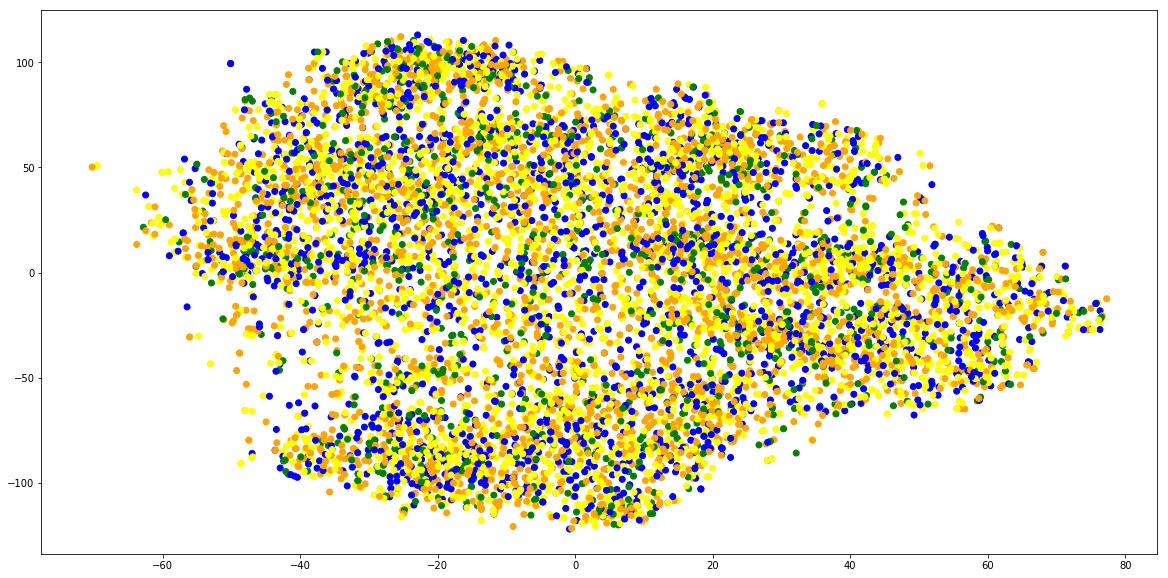

In [106]:
plt.figure(figsize=(20,10))
plt.scatter(X_tsne40[:,0], X_tsne40[:,1], c=colors)

In [84]:
#12:"olive",
colormap = {
#     18:"darkgreen", 17:"dodgerblue", 16:"maroon", 15:"peru", 14:"darkorchid", 
#             13:"blueviolet", 12:"olive", 11:"purple", 10:"wheat", 9:"yellowgreen", 
#             8:"turquoise", 7:"lavender", 6:"grey", 5:"fuchsia", 
    4:"pink", 3: "red", 2: 'orange', 
    1: 'green', 0: 'blue'}
colors = [colormap[v] for v in pred_class]

([], <a list of 0 Text yticklabel objects>)

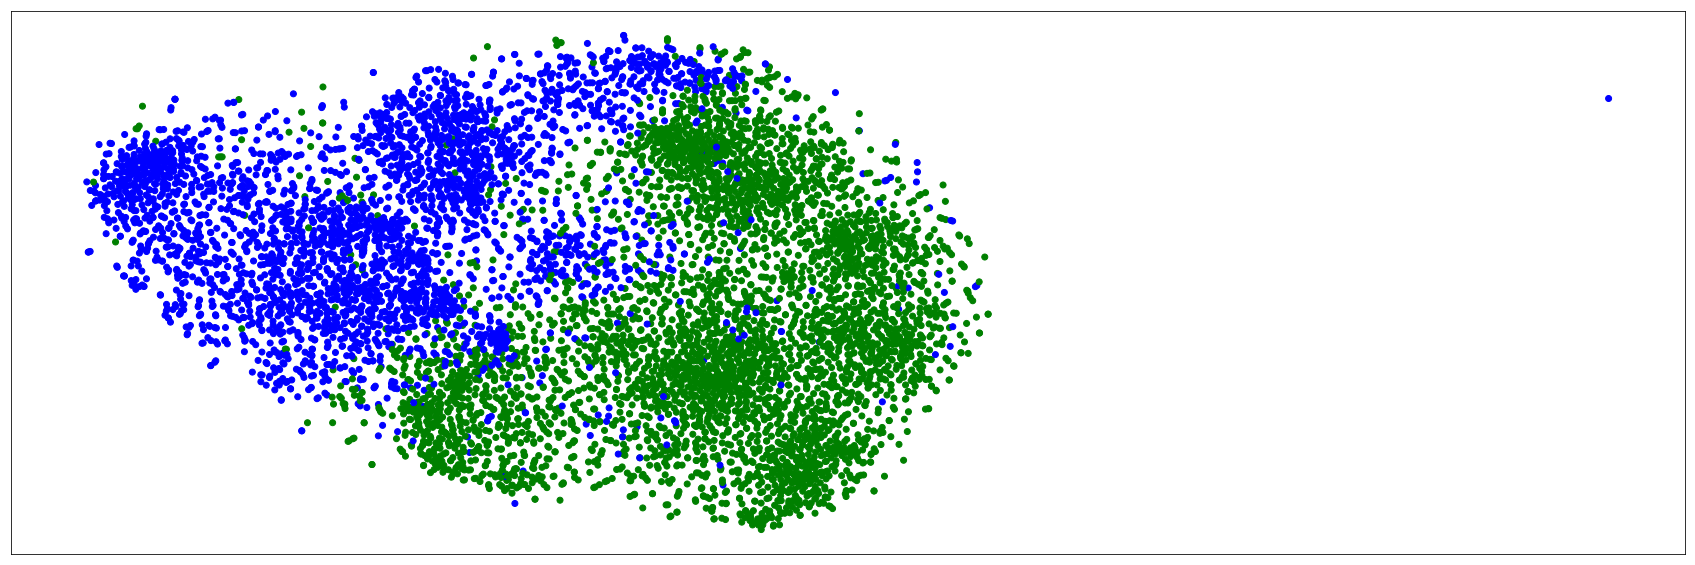

In [85]:
plt.figure(figsize=(30,10))
plt.scatter(X_tsne40[:,0], X_tsne40[:,1], c=colors)
plt.xticks([])
plt.yticks([])

In [ ]:
scaler = StandardScaler()
raw_data_scaled = scaler.fit_transform(raw_data)

In [ ]:
def svd_tfidf(data, vocab):
    
    count_mat = np.zeros((len(data), len(vocab)))
    
    for idx, token_list in enumerate(data):
        for t in token_list:
            if t != 0:
                count_mat[idx, t-1] +=1
                
    tfidf = TfidfTransformer()
    tfidf_mat = tfidf.fit_transform(count_mat)
    
    svd = TruncatedSVD(n_components=100)
    svd_mat = svd.fit_transform(tfidf_mat)
    
    return svd_mat